In [1]:
import os
import cv2
import keras
import random
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import keras
from keras.layers import Input, Conv2D, BatchNormalization, MaxPooling2D, Dropout, Flatten, Dense
from keras.models import Model
import pandas as pd
import warnings
import seaborn as sns
from keras.models import Sequential
from keras.layers import Dense, Conv2D , MaxPool2D , Flatten , Dropout , BatchNormalization
from sklearn.metrics import classification_report,confusion_matrix
from keras.callbacks import ReduceLROnPlateau

# Ignore all warnings
warnings.filterwarnings("ignore")

2024-05-21 20:43:08.186251: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-21 20:43:08.186366: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-21 20:43:08.320245: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
PATH = "/kaggle/input/datascientists-signtures/Deep learning dataset_cleaned"

In [3]:
from itertools import combinations

def generate_Pos_pairs(original_images):
    pos_pairs = []
    labels = []

    for img1, img2 in combinations(original_images, 2):
        pos_pairs +=[[img1, img2]]
        labels += [1]

    return pos_pairs, labels

def generate_Neg_pairs(orginal_images,forged_images):
    neg_pairs = []
    labels = []
    i=0
    for x1 in orginal_images :
        if i == 10:
            break
        i+=1
        for x2 in forged_images :
            neg_pairs += [[x1, x2]]
            labels += [0]
            
    return neg_pairs,labels
def preProcessImage(imagepath,target_size=(224,224)):
    image = cv2.imread(imagepath, cv2.IMREAD_GRAYSCALE)
    image = cv2.resize(image, target_size)
    image=np.reshape(image,(*target_size,1))
    image = image / 255.0
    return image
    

# Loading the Raw Data and Generate suitable dataset

In [4]:
from tensorflow.keras.preprocessing import image

def generate_data(path):
    folders = os.listdir(path) # all Ids
    all_pairs = []
    labels = []
    target_size = (224, 224)
    for ID in folders:
        
        current_path = os.path.join(path, ID) #  till 2020****
        
        if os.path.isdir(current_path): # Is it a valid directory ?
            try:
                his_folders = os.listdir(current_path) # original and forged folders
                current_forged_images = []
                current_orginal_images = []
                for folder in his_folders:

                    folder_path = os.path.join(current_path, folder)

                    if os.path.isdir(folder_path):

                        for img_name in os.listdir(folder_path):

                            # Read image in grayscale
                            imgpath =os.path.join(folder_path, img_name)
                            img=preProcessImage(imgpath)
                            if folder_path == os.path.join(current_path,f"{ID}_forged"): # then we're in forged folder
                                current_forged_images.append(img)

                            else:
                                current_orginal_images.append(img)
                # now we have 2 prepared lists of images want to build pairs of them
                POS_pairs,POS_labels = generate_Pos_pairs(current_orginal_images)
                NEG_pairs,NEG_labels = generate_Neg_pairs(current_orginal_images,current_forged_images)

                for pair , label in zip(POS_pairs,POS_labels):
                    all_pairs.append(pair)
                    labels.append(label)
                for pair , label in zip(NEG_pairs,NEG_labels):
                    all_pairs.append(pair)
                    labels.append(label)
            except:
                print("Not Valid: ",ID)
    return np.array(all_pairs), np.array(labels) 

all_pairs,all_labels = generate_data(PATH)

In [5]:
print(all_pairs.shape)
print(all_labels.shape)

(4651, 2, 224, 224, 1)
(4651,)


In [6]:
pd.DataFrame(all_labels).value_counts()

# Unbalancing problem solved by limit the images taken from the forged images

0
0    2330
1    2321
Name: count, dtype: int64

Text(0.5, 1.0, 'Column Graph of Value Counts')

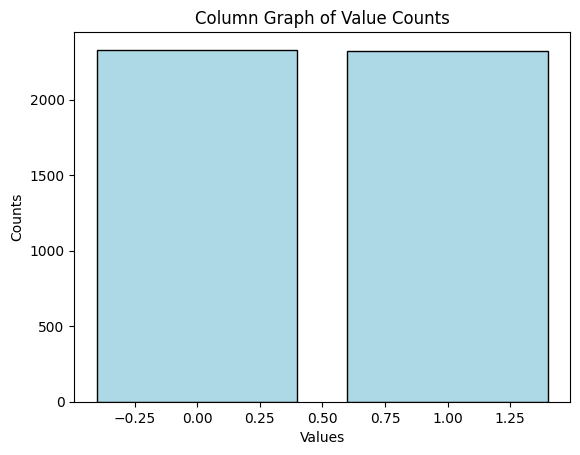

In [7]:
plt.bar([0,1], pd.DataFrame(all_labels).value_counts(), color='lightblue', edgecolor='black')

# Add labels and title
plt.xlabel('Values')
plt.ylabel('Counts')
plt.title('Column Graph of Value Counts')

In [8]:
X, y = all_pairs , all_labels

print('the X shape is ' ,X.shape)
print('the y shape is ' ,y.shape)

the X shape is  (4651, 2, 224, 224, 1)
the y shape is  (4651,)


## display some samples

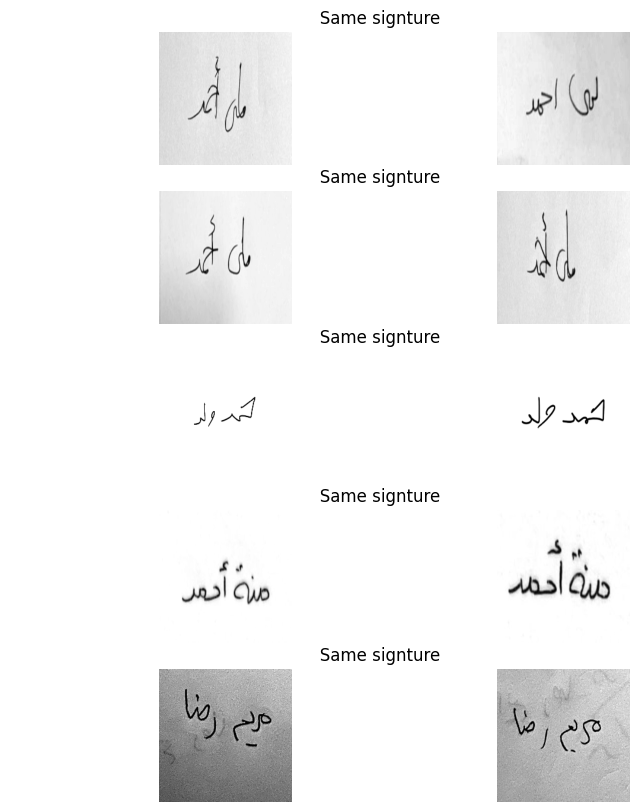

In [9]:
import matplotlib.pyplot as plt
import random

def plot_sample_pairs(image_pairs, labels, num_samples=5):
    # Randomly select indices for the samples
    sample_indices = random.sample(range(len(image_pairs)), num_samples)
    fig, axes = plt.subplots(num_samples, 2, figsize=(8, 2 * num_samples))
    for i, index in enumerate(sample_indices):
        img1, img2 = image_pairs[index]
        label = labels[index]
    
        axes[i, 0].imshow(img1.squeeze(), cmap='gray')
        if label==1:
            axes[i, 0].set_title('                                                           Same signture')
        else:
            axes[i, 0].set_title('                                                          Different signtures')
        axes[i, 0].axis('off')

        axes[i, 1].imshow(img2.squeeze(), cmap='gray')
        axes[i, 1]
        axes[i, 1].axis('off')

    plt.show()

# Example usage:
# Assuming X is a list of pairs and Y is a list of corresponding labels
# X, Y = generate_Pos_pairs(orginal_images)
plot_sample_pairs(X, y, num_samples=5)


## Split the dataset 

In [10]:
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [11]:
np.unique(y_train, return_counts=True)

(array([0, 1]), array([1856, 1864]))

# Building the Model

In [12]:
import keras
from keras.layers import Input, BatchNormalization, Conv2D, MaxPooling2D, Flatten, Dense, Dropout

def embedding_network(in_shape):
    input_layer = keras.layers.Input(in_shape)
    x = keras.layers.BatchNormalization()(input_layer)
    
    x = keras.layers.Conv2D(20, (5, 5), activation="relu")(x)
    x = keras.layers.MaxPooling2D(pool_size=(2, 2))(x)
    
    x = keras.layers.Conv2D(38, (3, 3), activation="relu")(x)
    x = keras.layers.AveragePooling2D(pool_size=(2, 2))(x)
    
    x = keras.layers.Conv2D(8, (3, 3), activation="relu")(x)
    x = keras.layers.AveragePooling2D(pool_size=(2, 2))(x)
    x = keras.layers.Dropout(0.1)(x)
    
    x = keras.layers.Flatten()(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Dense(128, activation="relu")(x)
    x = keras.layers.Dropout(0.5)(x)
    x = keras.layers.Dense(72, activation="relu")(x)
    x = keras.layers.Dropout(0.5)(x)
    x = keras.layers.Dense(25, activation="relu")(x)
    
    return keras.Model(inputs=input_layer, outputs=x)


In [13]:
def SiameseNetwork(in_shape):
    # 2.1. Define the twin networks using the embedding network
    input_1 = keras.layers.Input(in_shape)
    input_2 = keras.layers.Input(in_shape)
    
    # The siamese network shares weights between twin networks. 
    #To allow this, we will use the same embedding network for both networks.
    embedding_net_obj = embedding_network(in_shape)
    
    twin_1 = (embedding_net_obj)(input_1)
    twin_2 = (embedding_net_obj)(input_2)
    
    # 2.2. Define the energy function
    def cosine_similarity(vectors):
        vector1, vector2 = vectors

        norm_vector1 = keras.ops.sqrt(keras.ops.sum(keras.ops.square(vector1), axis=1, keepdims=True))
        norm_vector2 = keras.ops.sqrt(keras.ops.sum(keras.ops.square(vector2), axis=1, keepdims=True))

        dot_product = keras.ops.sum(vector1 * vector2, axis=1, keepdims=True)

        cosine_sim = dot_product / (norm_vector1 * norm_vector2 + keras.backend.epsilon()) 
        return cosine_sim
    
    # 2.3. Merge the twin networks using the energy function
    merge_layer = keras.layers.Lambda(cosine_similarity, output_shape=(1,))([twin_1, twin_2])
    
    # 2.4. Normalize and send to sigmoid (optional step)
    norm_layer = keras.layers.BatchNormalization()(merge_layer)
    output_layer = keras.layers.Dense(1, activation="sigmoid")(norm_layer)
    
    return keras.Model(inputs=[input_1, input_2], outputs=output_layer)

In [14]:
img_shape = (224,224,1)

siamese_model = SiameseNetwork(img_shape)
siamese_model.compile(loss='binary_crossentropy', optimizer="adam", metrics=['accuracy'])
siamese_model.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_1       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ functional_1        │ (None, 25)        │    735,243 │ input_layer[0][0… │
│ (Functional)        │                   │            │ input_layer_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda (Lambda)     │ (None, 1)         │          0 │ functional_1[0][… │
│                     │                   │            │ functional_1[1][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 1)         │          4 │ lambda[0][0]      │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 1)         │          2 │ batch_normalizat… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 735,249 (2.80 MB)

 Trainable params: 724,429 (2.76 MB)

 Non-trainable params: 10,820 (42.27 KB)

# Train the model 

In [15]:
history = siamese_model.fit(
    [x_train[:,0], x_train[:,1]],
    y_train,
    validation_data=([x_test[:,0], x_test[:,1]], y_test),
    batch_size=32,
    epochs=25,
)

Epoch 1/25
  5/117 ━━━━━━━━━━━━━━━━━━━━ 4s 36ms/step - accuracy: 0.5304 - loss: 0.7836 

I0000 00:00:1716324241.392803     104 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


117/117 ━━━━━━━━━━━━━━━━━━━━ 43s 182ms/step - accuracy: 0.5167 - loss: 0.7873 - val_accuracy: 0.4962 - val_loss: 0.8161
Epoch 2/25
  5/117 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - accuracy: 0.6394 - loss: 0.6738

W0000 00:00:1716324262.522269     104 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


117/117 ━━━━━━━━━━━━━━━━━━━━ 4s 34ms/step - accuracy: 0.5477 - loss: 0.7259 - val_accuracy: 0.4995 - val_loss: 0.8307
Epoch 3/25
117/117 ━━━━━━━━━━━━━━━━━━━━ 4s 34ms/step - accuracy: 0.5465 - loss: 0.7155 - val_accuracy: 0.4973 - val_loss: 0.8418
Epoch 4/25
117/117 ━━━━━━━━━━━━━━━━━━━━ 4s 34ms/step - accuracy: 0.5476 - loss: 0.6974 - val_accuracy: 0.5027 - val_loss: 0.8567
Epoch 5/25
117/117 ━━━━━━━━━━━━━━━━━━━━ 4s 34ms/step - accuracy: 0.5533 - loss: 0.6887 - val_accuracy: 0.5403 - val_loss: 0.7599
Epoch 6/25
117/117 ━━━━━━━━━━━━━━━━━━━━ 4s 34ms/step - accuracy: 0.5810 - loss: 0.6680 - val_accuracy: 0.5596 - val_loss: 0.7249
Epoch 7/25
117/117 ━━━━━━━━━━━━━━━━━━━━ 4s 34ms/step - accuracy: 0.6369 - loss: 0.6392 - val_accuracy: 0.5510 - val_loss: 0.7502
Epoch 8/25
117/117 ━━━━━━━━━━━━━━━━━━━━ 4s 34ms/step - accuracy: 0.6587 - loss: 0.6220 - val_accuracy: 0.6327 - val_loss: 0.6691
Epoch 9/25
117/117 ━━━━━━━━━━━━━━━━━━━━ 4s 34ms/step - accuracy: 0.6647 - loss: 0.6132 - val_accuracy: 0.659

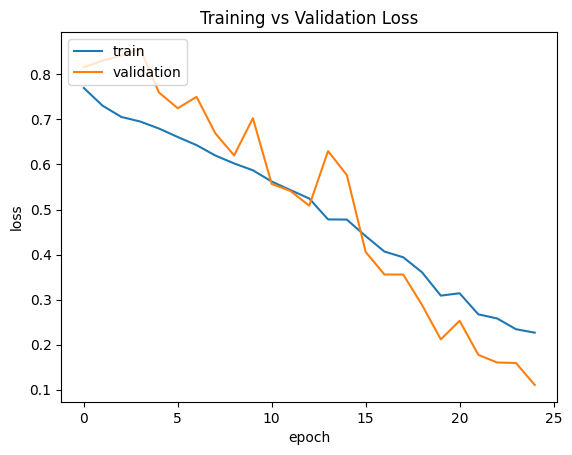

In [16]:
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.legend(["train", "validation"], loc="upper left")
plt.title("Training vs Validation Loss")
plt.ylabel("loss")
plt.xlabel("epoch")
plt.show()

# model predictions

30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9618 - loss: 0.1168
test loss, test acc: [0.11044356226921082, 0.9634801149368286]
30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step


W0000 00:00:1716324364.431695     102 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


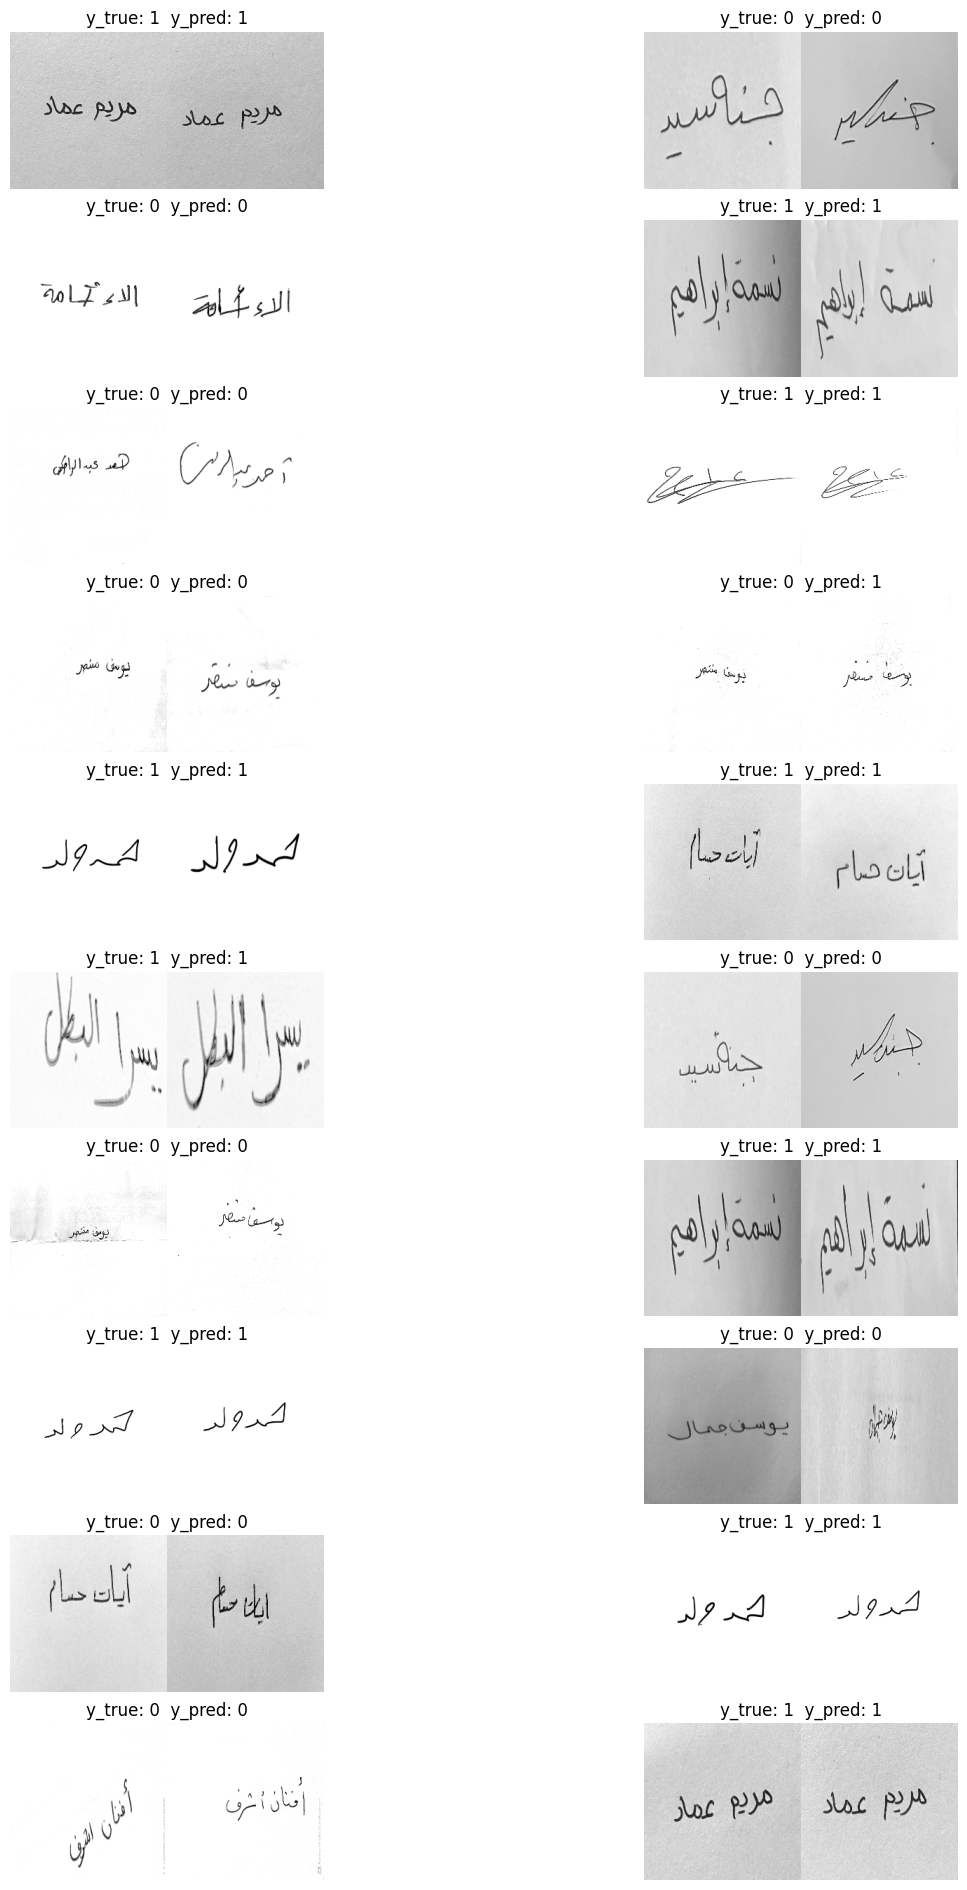

In [17]:
def displayPredictions(x_test,y_test,model):
    results = model.evaluate([x_test[:,0], x_test[:,1]], y_test)
    print("test loss, test acc:", results)
    predictions = model.predict([x_test[:,0], x_test[:,1]])
    fig, axes = plt.subplots(10, 2, figsize=(15, 24))
    for i in range(20):
        ax = axes[i // 2, i % 2]
        img_idx = random.randint(0, len(x_test))
        ax.imshow(keras.ops.concatenate([x_test[img_idx][0], x_test[img_idx][1]], axis=1), cmap='gray')
        ax.set_title("y_true: {}".format(y_test[img_idx]) + "  y_pred: {}".format(int(predictions[img_idx][0]>0.5)))
        ax.axis('off')
    return predictions
model1Predictions=displayPredictions(x_test,y_test,siamese_model)

## Confusion Matrix & Classification Report 

In [18]:
from sklearn.metrics import confusion_matrix, classification_report
def createReport(y_test,predictions):
    binary_predictions = (predictions > 0.5).astype(int)

    # Calculate confusion matrix
    conf_matrix = confusion_matrix(y_test, binary_predictions)

    # Print confusion matrix
    print("Confusion Matrix:")
    print(conf_matrix)

    # Calculate and print classification report
    class_report = classification_report(y_test, binary_predictions)
    print("Classification Report:")
    print(class_report)
createReport(y_test,model1Predictions)

Confusion Matrix:
[[440  34]
 [  0 457]]
Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.93      0.96       474
           1       0.93      1.00      0.96       457

    accuracy                           0.96       931
   macro avg       0.97      0.96      0.96       931
weighted avg       0.97      0.96      0.96       931



## Test the model by Unseen Data

In [31]:
path1='/kaggle/input/datascientists-signtures/Deep learning dataset_cleaned/20207008/20207008_original/CamScanner 03-09-2024 00.59_page-0001.jpg'
path2='/kaggle/input/datascientists-signtures/Deep learning dataset_cleaned/20207008/20207008_forged/forged_page-0002.jpg'

In [32]:
def compareSigns(path1,path2,model):
    img1=preProcessImage(path1)
    img2=preProcessImage(path2)
#     model.predict([x_test[:,0], x_test[:,1]])
    
    img1=img1.reshape((1,224,224,1))
    img2=img2.reshape((1,224,224,1))
    
    predictions=model.predict([img1,img2])
    print(predictions)
    print("  y_pred: {}".format(int(predictions[0]>0.5)))
compareSigns(path1,path2,siamese_model)
    

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
[[0.01402755]]
  y_pred: 0
